<a href="https://colab.research.google.com/github/JINYUHOON/VIS_temp/blob/main/06_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import math


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.applications import EfficientNetB0

# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [ ]:
def get_model(input_shape):
    
    inputs = keras.Input(input_shape)
    base_model = EfficientNetB0(
        input_shape = input_shape,
        weights = 'imagenet',
        include_top=False,
        pooling = 'avg'
    )
    
    x = base_model(inputs)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    return model

input_shape = (256, 256, 3)
model = get_model(input_shape)

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)

model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from albumentations.augmentations.transforms import ShiftScaleRotate
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode =='train':
            self.transform = A.Compose([
                                   A.HorizontalFlip(p=0.5),
                                   A.ShiftScaleRotate(
                                       p = 0.5,
                                       shift_limit = 0.05,
                                       scale_limit = 0.05,
                                       rotate_limit = 15,
                                   ),
                                #    A.CoarseDropout(
                                #        p=0.5,
                                #        max_holes = 8,
                                #        max_height = int( 0.1 * size),
                                #        max_width = int( 0.1 * size)    
                                #    ),
                                   A.RandomBrightnessContrast(p=0.2),
            ])
    

    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [ ]:
base_path = '/content/drive/MyDrive/HOON/exam/OX/data/'

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.mode = mode
        self.image_size = image_size
        self.shuffle = shuffle

        self.df = pd.read_csv(csv_path)

        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode =='val':
            self.df = self.df[self.df['fold'] == self.fold]

        # Remove invalid
        invalid_filenames = [
                             'Egyptian_Mau_14',
                             'Egyptian_Mau_139',
                             'Egyptian_Mau_145',
                             'Egyptian_Mau_156',
                             'Egyptian_Mau_167',
                             'Egyptian_Mau_177',
                             'Egyptian_Mau_186',
                             'Egyptian_Mau_1191',
                             'Abyssinian_5',
                             'Abyssinian_34',
                             'chihuahua_121',
                             'beagle_116'
                             
        ]

        self.df = self.df[-self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size , mode)

        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx+1) * self.batch_size
        data = self.df.iloc[strt:fin]

        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)

    def get_data(self, data):
        batch_x = []
        batch_y = []

        for _ , r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(base_path + f'images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image , (self.image_size , self.image_size))

            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)

            image = image.astype('float32')
            image = image / 255.

            label = int(r['species']-1)

            batch_x.append(image)
            batch_y.append(label)

        return batch_x, batch_y

    def on_epoch_end(self):

        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

csv_path = base_path + 'kfolds.csv'

train_generator = DataGenerator(batch_size = 64, 
                                csv_path=csv_path, fold = 1, 
                                image_size = 256,
                                mode='train', 
                                shuffle=True)

valid_generator = DataGenerator(batch_size = 64, 
                                csv_path=csv_path, fold = 1, 
                                image_size = 256,
                                mode='val', 
                                shuffle=True)

In [ ]:
history = model.fit(train_generator, validation_data = valid_generator, epochs=10, verbose=1)

Epoch 1/10
92/92 [==============================] - 4141s 45s/step - loss: 0.1773 - accuracy: 0.9501 - val_loss: 0.6812 - val_accuracy: 0.6780
Epoch 2/10
92/92 [==============================] - 67s 726ms/step - loss: 0.0354 - accuracy: 0.9893 - val_loss: 0.6992 - val_accuracy: 0.3220
Epoch 3/10
92/92 [==============================] - 68s 730ms/step - loss: 0.0169 - accuracy: 0.9947 - val_loss: 0.6881 - val_accuracy: 0.5398
Epoch 4/10
92/92 [==============================] - 67s 725ms/step - loss: 0.0112 - accuracy: 0.9971 - val_loss: 0.7176 - val_accuracy: 0.3376
Epoch 5/10
92/92 [==============================] - 67s 725ms/step - loss: 0.0108 - accuracy: 0.9964 - val_loss: 0.7154 - val_accuracy: 0.3363
Epoch 6/10
92/92 [==============================] - 68s 731ms/step - loss: 0.0058 - accuracy: 0.9986 - val_loss: 1.2408 - val_accuracy: 0.3581
Epoch 7/10
92/92 [==============================] - 67s 726ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 1.3723 - val_accuracy: 0.3921

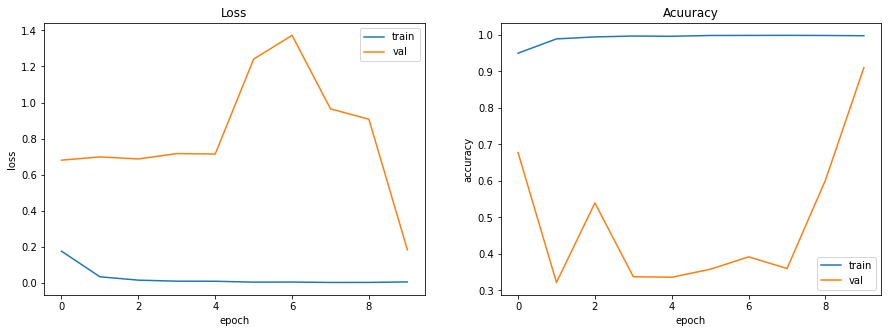

In [ ]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(122)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Acuuracy')

plt.show()